# Data Science Challenge

### Lefteris Vazaios

In [1]:
# import libraries
import pandas as pd
import glob
import os
import datetime
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

For setting the path:
Copy the location where the files are located. 
If on Windows, use double backslash for separator (\\) because single backslash is an escape character.
Depending on OS, path might work as is (without running the replacement). To make sure, you can manually replace every separator with '\\' and let the os.sep method do the work.

In [2]:
# set path where files are located 
# (used \\ because it is a windows environment and \ is an escape character)
path = 'C:\\Users\\lefte\\Desktop\\Data Science Challenge\\all journeys'
path = path.replace('\\', os.sep)


The following code reads all csv files from the specified directory. If we want, we can read any file extension. We can also print the files as they are being read. 

Because some column names had leading and/or trailing blanks, those have been trimmed.

In [3]:
# read each file, while assigning to it a journey id
journeys = pd.DataFrame()
i = 0

for filename in glob.glob(os.path.join(path, '*.csv')):
    #print(filename)
    current_journey = pd.read_csv(filename)
    current_journey = current_journey.rename(columns=lambda x: x.strip())
    current_journey['Journey_ID'] = i
    journeys = journeys.append(current_journey)
    i += 1
    
journeys.sample(5)


,Journey_ID,accuracy,bearing,height,lat,lon,speed,timestamp,type,x,y,z
16194,18,NaN,NaN,NaN,NaN,NaN,NaN,1.435093e+12,accelerometer,1.014358,-0.058289,-0.040176
4367,10,NaN,NaN,NaN,NaN,NaN,NaN,1.434832e+12,accelerometer,0.073318,-0.781967,-0.563446
1516,13,10.0,0.000000,25.949043,27.946951,-82.269370,20.83,1.434719e+12,gps,NaN,NaN,NaN
3236,15,NaN,NaN,NaN,NaN,NaN,NaN,1.426798e+12,accelerometer,-0.760010,0.519073,0.085663
2679,8,10.0,181.054688,189.120182,42.533029,-83.048006,12.77,1.421059e+12,gps,NaN,NaN,NaN


In [4]:
# get timestamp in readable format
def dt_conv(x):
    s = x/1000.0
    return datetime.datetime.fromtimestamp(s).strftime('%Y-%m-%d %H:%M:%S.%f')
    
journeys['timestamp'] = journeys['timestamp'].apply(lambda x: dt_conv(x))
journeys.head(5)


,Journey_ID,accuracy,bearing,height,lat,lon,speed,timestamp,type,x,y,z
0,0,5.0,179.648438,230.88541,44.77757,-85.383821,14.73,2015-06-21 01:17:56.097070,gps,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-06-21 01:17:56.130070,accelerometer,-0.423553,-0.466202,-0.684189
2,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-06-21 01:17:56.229070,accelerometer,-0.479645,-0.532272,-0.728424
3,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-06-21 01:17:56.328070,accelerometer,-0.418701,-0.529617,-0.632751
4,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-06-21 01:17:56.429070,accelerometer,-0.415421,-0.459091,-0.654221


Next up, I fixed the accelerometer values since some of them could be in G while others in m/s2. This is only necessary in one of the approaches. 

There are several ways to do this. What I did was get the max of x, y, z for each row and then the max of that for each Journey_ID. Assuming that acceleration values of over 5 m/s2 are extremely unlikely to appear on the road (a Jaguar XK can reach about 6m/s2 at best), any journeys with a max value over 5 had their x, y, z values divided by 9.81.

Another option would be standardisation, but that would most likely hinder anomaly detection.

In [5]:
# fix accelerometer unit of measure 
# a fast car can reach an acceleration of around 6 to 6.5 m/s2
# there are also speed limits to take into account
# any max acceleration values of over 5 are assumed to be in m/s2
# similarly, decelaration is affected by speed

condition = (journeys.loc[:, ('Journey_ID', 'x', 'y', 'z')].groupby(['Journey_ID']).max().max(1)) > 5
acc_in_ms2 = condition[condition == True].index
condition2 = journeys['Journey_ID'].isin(acc_in_ms2)

journeys.loc[condition2, 'x'] = journeys.loc[condition2, 'x'].apply(lambda x: x/9.81)
journeys.loc[condition2, 'y'] = journeys.loc[condition2, 'y'].apply(lambda x: x/9.81)
journeys.loc[condition2, 'z'] = journeys.loc[condition2, 'z'].apply(lambda x: x/9.81)


Due to the nature of the data, all gps measurements have empty accelerometer values while all accelerometer measurements have empty location, speed, etc.

As such, I used forward fill (and then backward for a single remaining row) to fill the missing values.

In [6]:
# fill na with previous value (to fix empty gps and empty accelerometer)
journeys.fillna(method = 'ffill', inplace = True)
journeys.fillna(method = 'bfill', inplace = True)


For some of the algorithms tried, it was useful to see how one single variable changes overtime. As such, I created the acceleration variable as the absolute max (retaining sign) of the x, y, z values.

In [7]:
# create accelerometer value regardless of axis (the absolute max of x,y, z at any given time)
maxCol=lambda x: max(x.min(), x.max(), key=abs)
journeys['acceleration'] = journeys[['x', 'y', 'z']].apply(maxCol,axis=1)


Using this variable, we can see that some journeys clearly have anomalies while others do not.

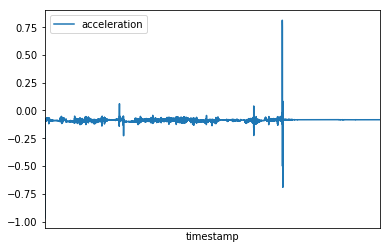

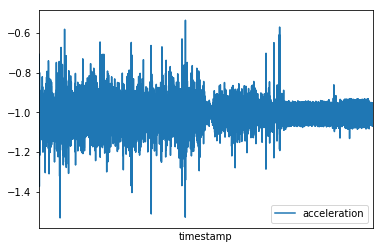

In [35]:

journeys[(journeys.Journey_ID == 21)].plot(x = 'timestamp', y = 'acceleration')
plt.xticks([])
plt.show()

journeys[(journeys.Journey_ID == 14)].plot(x = 'timestamp', y = 'acceleration')
plt.xticks([])
plt.show()




As a simple first solution, I calculated the moving average of the acceleration for each journey. Cases where acceleration is quite far (6 standard deviations) from the rolling mean are considered anomalies.

Three other, more complicated algorithms that I used were Local Outlier Factor (LOF), one-class SVM and Isolation Forest. SVM by default tries to separate two groups of roughly equal size; even by tuning the parameters, we get a lot of anomalies (disproportionate to the expected amount of accidents). Isolation Forest works well with a large number of features which we did not have. I could have generated new features (e.g. polynomial terms) but this is more of a suggestion that might or might not work.

All those models assume there is at least 1 outlier in the data. As such, they will always identify at least one observation.

In [8]:
outliers_fraction = 0.0001
min_max_scaler = preprocessing.StandardScaler()
journeys_scored = pd.DataFrame()

for i in range(len(journeys.Journey_ID.unique())):
    df = journeys[(journeys.Journey_ID == i)]
    # moving average
    data_ma = journeys[(journeys.Journey_ID == i)].loc[:, ('acceleration')].abs()
    r = data_ma.rolling(window=45)  # Create a rolling object (no computation yet)
    mps = r.mean() + 6 * r.std()  # Combine a mean and stdev on that object
    df['anomaly_ma'] = pd.Series(data_ma > mps)
    df['anomaly_ma'] = df['anomaly_ma'].map( {False: 0, True: 1} )
    
    # LOF
    data_lof = journeys[(journeys.Journey_ID == i)].loc[:, ('acceleration', 'speed', 'bearing')]
    np_scaled = min_max_scaler.fit_transform(data_lof)
    model_lof = LocalOutlierFactor(n_neighbors=50, contamination = outliers_fraction)
    data_lof = pd.DataFrame(np_scaled)
    model_lof.fit(data_lof)
    df['anomaly_lof'] = pd.Series(model_lof.fit_predict(data_lof))
    df['anomaly_lof'] = df['anomaly_lof'].map( {1: 0, -1: 1} )
    
    # one-class SVM
    data_svm = journeys[(journeys.Journey_ID == i)].loc[:, ('acceleration', 'speed', 'bearing')]
    np_scaled = min_max_scaler.fit_transform(data_svm)
    model_svm = OneClassSVM(nu = outliers_fraction)
    data_svm = pd.DataFrame(np_scaled)
    model_svm.fit(data_svm)
    df['anomaly_svm'] = pd.Series(model_svm.predict(data_svm))
    df['anomaly_svm'] = df['anomaly_svm'].map( {1: 0, -1: 1} )
    
    # Isolation Forest
    data_if = journeys[(journeys.Journey_ID == i)].drop(['timestamp', 'type'], axis = 1)
    np_scaled = min_max_scaler.fit_transform(data_if)
    model_if = IsolationForest(contamination = outliers_fraction)
    data_if = pd.DataFrame(np_scaled)
    model_if.fit(data_if)
    df['anomaly_if'] = pd.Series(model_if.predict(data_if))
    df['anomaly_if'] = df['anomaly_if'].map( {1: 0, -1: 1} )

    
    journeys_scored = journeys_scored.append(df)
    #print(df['anomaly_ma'].value_counts())

# check which journeys have anomalies    
# journeys_scored.loc[journeys_scored['anomaly_ma'] == 1, ['Journey_ID']].Journey_ID.unique()
# journeys_scored.loc[journeys_scored['anomaly_lof'] == 1, ['Journey_ID']].Journey_ID.unique()
# journeys_scored.loc[journeys_scored['anomaly_svm'] == 1, ['Journey_ID']].Journey_ID.unique()
# journeys_scored.loc[journeys_scored['anomaly_if'] == 1, ['Journey_ID']].Journey_ID.unique()

Assume the observation is an anomaly if at least 2 models score it as such. We can make this more strict by requiring 3 models to score it like this.

In [9]:
anomaly_condition = (journeys_scored['anomaly_ma'] + journeys_scored['anomaly_lof'] + 
journeys_scored['anomaly_svm'] + journeys_scored['anomaly_if']) > 1

journeys_scored.loc[anomaly_condition, ['Journey_ID']].Journey_ID.unique()

array([ 2,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23,
       24], dtype=int64)

Another approach is to handle all time series as a single one. This assumes that all the vehicles are roughly the same, all drivers drive quite similar and the roads/weather conditions are also similar. This produces a simpler model but could perhaps generalise better. 

In this case, I only used moving average and local outlier factor.

This approach is the reason I modified the accelerometer values (and a case where standardisation might work).

In [10]:
# Moving Average2
data_ma2 = journeys_scored.loc[:, ('acceleration')].abs()
r = data_ma2.rolling(window=40)  # Create a rolling object (no computation yet)
mps = r.mean() + 6 * r.std()  # Combine a mean and stdev on that object
journeys_scored['anomaly_ma2'] = pd.Series(data_ma2 > mps)
journeys_scored['anomaly_ma2'] = journeys_scored['anomaly_ma2'].map( {False: 0, True: 1} )

# LOF2
data_lof2 = journeys_scored.loc[:, ('acceleration', 'speed', 'bearing')]
np_scaled = min_max_scaler.fit_transform(data_lof2)
model_lof2 = LocalOutlierFactor(n_neighbors=5, contamination = outliers_fraction)
data_lof2 = pd.DataFrame(np_scaled)
model_lof2.fit(data_lof2)
journeys_scored['anomaly_lof2'] = pd.Series(model_lof2.fit_predict(data_lof2))
journeys_scored['anomaly_lof2'] = journeys_scored['anomaly_lof2'].map( {1: 0, -1: 1} )

#print(journeys_scored['anomaly_ma2'].value_counts())
#journeys_scored.loc[journeys_scored['anomaly_ma2'] == 1, ['Journey_ID']].Journey_ID.unique()
#print(journeys_scored['anomaly_lof2'].value_counts())
#journeys_scored.loc[journeys_scored['anomaly_lof2'] == 1, ['Journey_ID']].Journey_ID.unique()

We can now create a new condition that combines both approaches.

In [11]:
anomaly_condition2 = (journeys_scored['anomaly_ma'] + journeys_scored['anomaly_lof'] + 
                      journeys_scored['anomaly_svm'] + journeys_scored['anomaly_if'] + 
                      journeys_scored['anomaly_ma2'] + journeys_scored['anomaly_lof2']) > 2
journeys_scored.loc[anomaly_condition2, ['Journey_ID']].Journey_ID.unique()

array([ 2,  4,  5, 10, 12, 15, 21, 22], dtype=int64)

We can also get the timestamp of those anomalies, as well as which models identified them.

In [12]:
journeys_scored.loc[anomaly_condition2, ['Journey_ID', 'timestamp', 
                                         'anomaly_ma', 'anomaly_lof', 'anomaly_svm', 'anomaly_if',
                                        'anomaly_ma2', 'anomaly_lof2']]

,Journey_ID,timestamp,anomaly_ma,anomaly_lof,anomaly_svm,anomaly_if,anomaly_ma2,anomaly_lof2
5580,2,2015-04-20 04:30:45.258670,1,1,1,0,1,0
1042,4,2015-04-03 04:52:18.935260,1,0,1,0,1,0
10522,5,2015-03-16 18:09:29.263690,1,0,0,1,1,0
11716,5,2015-03-16 18:11:14.301690,1,0,0,1,1,0
11255,10,2015-06-20 23:35:20.896120,1,0,1,0,1,0
10229,12,2015-05-17 19:04:23.392600,1,0,1,0,1,0
35359,15,2015-03-19 23:37:29.228870,1,1,1,0,1,0
6495,21,2015-04-24 22:28:41.191820,1,0,1,0,1,0
1921,22,2015-03-16 23:56:35.278370,1,0,0,1,1,0


I have also provided two sample graphs showing the anomaly in relation to the acceleration variable. 

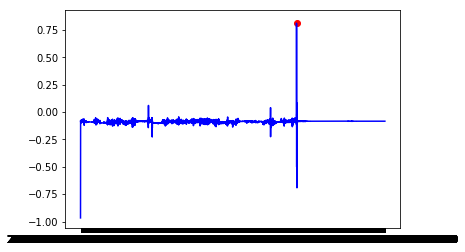

In [82]:
%matplotlib inline
fig, ax = plt.subplots()

a = journeys_scored.loc[(anomaly_condition2) & (journeys_scored['Journey_ID'] == 21), 
                        ['timestamp', 'acceleration']]
b = journeys_scored.loc[journeys_scored['Journey_ID'] == 21]

ax.plot(b['timestamp'], b['acceleration'], color='blue')
ax.scatter(a['timestamp'],a['acceleration'], color='red')
plt.show()

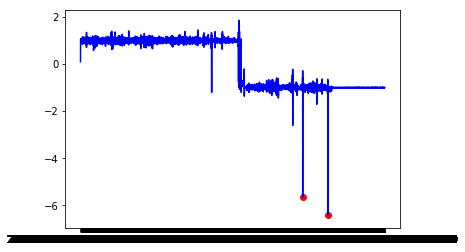

In [14]:
%matplotlib inline
fig, ax = plt.subplots()

a = journeys_scored.loc[(anomaly_condition2) & (journeys_scored['Journey_ID'] == 5), 
                        ['timestamp', 'acceleration']]
b = journeys_scored.loc[journeys_scored['Journey_ID'] == 5]

ax.plot(b['timestamp'], b['acceleration'], color='blue')
ax.scatter(a['timestamp'],a['acceleration'], color='red')
plt.show()

A simple severity index could be the speed or acceleration value at the point of the anomaly. Intuitively, if the acceleration is equal or larger (by absolute value) than the speed and has a negative sign, the event is probably more severe.

An attempt was made to create an index that gave more value to observations with high speed and low acceleration (ideally same speed and acceleration but different sign). These are presented below for the anomalies.

In [105]:
journeys_sev = journeys_scored.loc[anomaly_condition2, ['Journey_ID', 'timestamp', 
                                        'speed', 'acceleration']]
journeys_sev['sev_index'] = (
    journeys_sev['acceleration'])**2/abs(
    1 + journeys_sev['acceleration'] + journeys_sev['speed']
)

journeys_sev

,Journey_ID,timestamp,speed,acceleration,sev_index
5580,2,2015-04-20 04:30:45.258670,0.000000,3.904526,3.108419
1042,4,2015-04-03 04:52:18.935260,0.320000,0.340411,0.069790
10522,5,2015-03-16 18:09:29.263690,5.720000,-5.653305,29.961576
11716,5,2015-03-16 18:11:14.301690,1.770000,-6.411346,11.288506
11255,10,2015-06-20 23:35:20.896120,0.000000,-0.467373,0.410114
10229,12,2015-05-17 19:04:23.392600,2.440000,2.318878,0.933723
35359,15,2015-03-19 23:37:29.228870,0.000000,0.211794,0.037017
6495,21,2015-04-24 22:28:41.191820,11.940000,0.812399,0.047991
1921,22,2015-03-16 23:56:35.278370,16.209999,-4.153137,1.321033


Notionally, if an event is a crash, it will be followed by a long period of immobility. In this case, I defined 2 simple indexes as the acceleration and speed difference between the time of the anomaly and the average of the 100 next moments (timestaps).

In [108]:
indexes = journeys_sev.index.values
ids = journeys_sev.Journey_ID.values

acc_after = []
speed_after = []
for i in range (len(indexes)):
    acc_after.append(
        journeys[journeys['Journey_ID'] == ids[i]].loc[:indexes[i]].head(100).loc[:, 'acceleration'].mean())
    speed_after.append(
        journeys[journeys['Journey_ID'] == ids[i]].loc[:indexes[i]].head(100).loc[:, 'speed'].mean())

journeys_sev['acc_after'] = acc_after
journeys_sev['speed_after'] = speed_after
journeys_sev['conf_index1'] = abs(journeys_sev['acc_after']-journeys_sev['acceleration'])
journeys_sev['conf_index2'] = abs(journeys_sev['speed_after']-journeys_sev['speed'])
journeys_sev

,Journey_ID,timestamp,speed,acceleration,sev_index,acc_after,speed_after,conf_index1,conf_index2
5580,2,2015-04-20 04:30:45.258670,0.000000,3.904526,3.108419,-0.807143,6.4365,4.711669,6.436500
1042,4,2015-04-03 04:52:18.935260,0.320000,0.340411,0.069790,0.095340,5.9974,0.245071,5.677400
10522,5,2015-03-16 18:09:29.263690,5.720000,-5.653305,29.961576,0.990922,21.5390,6.644227,15.819000
11716,5,2015-03-16 18:11:14.301690,1.770000,-6.411346,11.288506,0.990922,21.5390,7.402268,19.769000
11255,10,2015-06-20 23:35:20.896120,0.000000,-0.467373,0.410114,-0.056242,7.9900,0.411131,7.990000
10229,12,2015-05-17 19:04:23.392600,2.440000,2.318878,0.933723,0.794992,12.0419,1.523886,9.601900
35359,15,2015-03-19 23:37:29.228870,0.000000,0.211794,0.037017,0.080598,2.6880,0.131196,2.688000
6495,21,2015-04-24 22:28:41.191820,11.940000,0.812399,0.047991,-0.088600,8.9630,0.901000,2.977000
1921,22,2015-03-16 23:56:35.278370,16.209999,-4.153137,1.321033,-0.807832,7.2399,3.345305,8.970099
